# Preliminary study

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import statistics
import scipy.stats

In [52]:
from scipy.stats import chi2_contingency

In [437]:
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [531]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [4]:
name = 'sample_200_0k_20170120.csv'
df = pd.read_csv(name)

In [5]:
df.head()

,gender,birthdate,maritalstatus,numofdependence,education,professionid,homestatus,staysinceyear,EmploymentSinceYear,MainBusinessSinceYear,...,std_sale_apartment_price_10000,sale_apartment_cnt_10000,avg_rent_house_price_10000,std_rent_house_price_10000,rent_house_cnt_10000,avg_rent_apartment_price_10000,std_rent_apartment_price_10000,rent_apartment_cnt_10000,previous,distance_residence_company
0,Male,1985-12-15T17:00:00.000+00:00,SINGLE,0,BACHELOR_DEGREE,Government employees,4,2010.0,2006.0,NaN,...,2.199754e+08,26.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.0
1,Male,1969-12-20T17:00:00.000+00:00,MARRIED,2,ELEMENTARY_SCHOOL,Entrepreneur,1,1992.0,NaN,2005.0,...,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,"2012-09-11 03:40:58,2850000.00,7,0.00",0.0
2,Female,1976-08-17T17:00:00.000+00:00,MARRIED,2,SENIOR_HIGH_SCHOOL,Entrepreneur,1,2008.0,NaN,2010.0,...,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.0
3,Male,1985-01-09T17:00:00.000+00:00,MARRIED,1,ELEMENTARY_SCHOOL,Entrepreneur,1,2002.0,NaN,2005.0,...,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.0
4,Female,1979-08-16T17:00:00.000+00:00,MARRIED,1,ELEMENTARY_SCHOOL,Entrepreneur,1,2007.0,NaN,2007.0,...,2.117290e+08,60.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.0


In [8]:
df.shape

(200000, 62)

In [10]:
# percentage of missing values in each row
df['missing_pct'] = df.isnull().sum(axis = 1)/df.shape[1]
# drop each row of the percentage > 25%
missing_row_idx = df[df['missing_pct'] > 0.25].index
df.drop(df.index[missing_row_idx], inplace = True)
df.shape

(200000, 63)

In [11]:
df.drop(columns = ['missing_pct'], inplace = True)

In [26]:
# percentage of missing values in each column
col_pct_missing = []
for col in df.columns:
    col_pct_missing.append(np.mean(df[col].isnull())*100)
col_missing_df = pd.DataFrame(col_pct_missing, index = df.columns, columns = ['pct_missing'])

In [27]:
col_missing_df

,pct_missing
gender,0.0000
birthdate,0.0000
maritalstatus,0.0040
numofdependence,0.0000
education,0.0000
...,...
avg_rent_apartment_price_10000,0.0000
std_rent_apartment_price_10000,0.0000
rent_apartment_cnt_10000,0.0000
previous,60.5110


In [28]:
# filter out columns with percentage of missing larger than 25%
col_missing_df[col_missing_df.pct_missing > 25]

,pct_missing
EmploymentSinceYear,45.5700
MainBusinessSinceYear,52.6585
jobpos,42.5775
previous,60.5110


I have considered using imputation but the percentage of missing in these columns is too large. Imputation will create bias. Therefore, I decided to not include these columns into the model, but "previous" will be included. Previous is the previous loan record. Will discuss later.

In [38]:
# create the target column
# If maxoverduedays>90, we say that the borrower has defaulted on the loan.
df['defaulted'] = df['MaxOverDueDays'] > 90

In [42]:
df['defaulted'].value_counts()

False    168883
True      31117
Name: defaulted, dtype: int64

([<matplotlib.patches.Wedge at 0x157192f16a0>,
 [Text(-0.9711945926318911, 0.5165085316261245, 'not defaulted'),
  Text(0.9711946168113992, -0.5165084861612244, 'defaulted')])

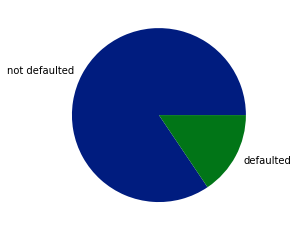

In [119]:
mylabels = ['not defaulted', 'defaulted']
plt.pie(df['defaulted'].value_counts(), labels = mylabels)

Balance the data using undersampling

In [281]:
#Seperate each target class into 2 dataframes
not_default = df[df['defaulted'] == 0]
default = df[df['defaulted'] == 1]

#Number of samples
N = 20000
rs = 1

#Resample dataframe
resample_default = resample(default,
                       replace = False,
                       n_samples = N,
                       random_state = rs)

resample_nondefault = resample(not_default,
                       replace = False,
                       n_samples = N,
                       random_state = rs)

resample_df = pd.concat([resample_default, resample_nondefault])

## Finding features

In [282]:
# categorical features 
cat = ['professionid', 'gender', 'maritalstatus', 'education', 'birthplace', \
       'residencezipcode', 'companyzipcode', 'legalzipcode']
resample_df[cat].head()

,professionid,gender,maritalstatus,education,birthplace,residencezipcode,companyzipcode,legalzipcode
36804,Private Employees,Male,SINGLE,BACHELOR_DEGREE,SELONG,83127.0,83121.0,83127.0
107878,Entrepreneur,Male,MARRIED,JUNIOR_HIGH_SCHOOL,BATURAJA,32114.0,32116.0,32114.0
29685,Entrepreneur,Male,MARRIED,SENIOR_HIGH_SCHOOL,MANDE,84119.0,84119.0,84119.0
93762,Entrepreneur,Female,MARRIED,SENIOR_HIGH_SCHOOL,MANTIKOLE,94361.0,94361.0,94361.0
142081,Entrepreneur,Female,WIDOWED,SENIOR_HIGH_SCHOOL,BANTAENG,92411.0,92415.0,92411.0


### Categorical features
We use chi-square test to see if these categorical features are correlated with the defaulted column. We do that by bootstrapping 1000 times on 5000 rows sampled from the dataframe and perform the hypothesis. Our null hypothesis is that each categorical feature is not statistically significant to the defaulted column. Alternative hypothesis is the opposite. When the p value is less than our default critical value 0.05, we reject the null hypothesis and conclude that the categorical feature is correlated with the defaulted column.

In [285]:
%time
from collections import defaultdict
pvalues = defaultdict(list)
for i in range(1000):
    sample = resample_df.sample(5000)
    for j in cat:
        data_crosstab = pd.crosstab(sample[j], sample['defaulted'], margins = False)
        pvalue = chi2_contingency(data_crosstab)[1]
        pvalues[j].append(pvalue) 

Wall time: 0 ns


In [286]:
pvalue_mean = []
pvalue_median = []
for k in pvalues.keys():
    pvalue_mean.append(np.mean(pvalues[k]))
    pvalue_median.append(statistics.median(pvalues[k]))

In [287]:
pval_df = pd.DataFrame(data={'mean':pvalue_mean, 'median':pvalue_median}, index = pvalues.keys())

In [130]:
def color_pvalue(value):
    """
    Colors elements in a dateframe
    red if statistically significant
    """

    if value < 0.05:
        color = 'red'
    else: color = 'black'

    return 'color: %s' % color

In [288]:
pval_df.style.applymap(color_pvalue)

,mean,median
professionid,0.000000,0.000000
gender,0.516915,0.522658
maritalstatus,0.040492,0.005291
education,0.000000,0.000000
birthplace,0.012901,0.006302
residencezipcode,0.004063,0.000910
companyzipcode,0.004453,0.001105
legalzipcode,0.004763,0.001253


From the table, we see that education, professoinid, residencezipcode, companyzipcode, and legalzipcode are statistically significant to the defaulted column because its mean and median of the p values are extremely small. Marital status is somewhat significant to the defaulted as its median less than 0.05.

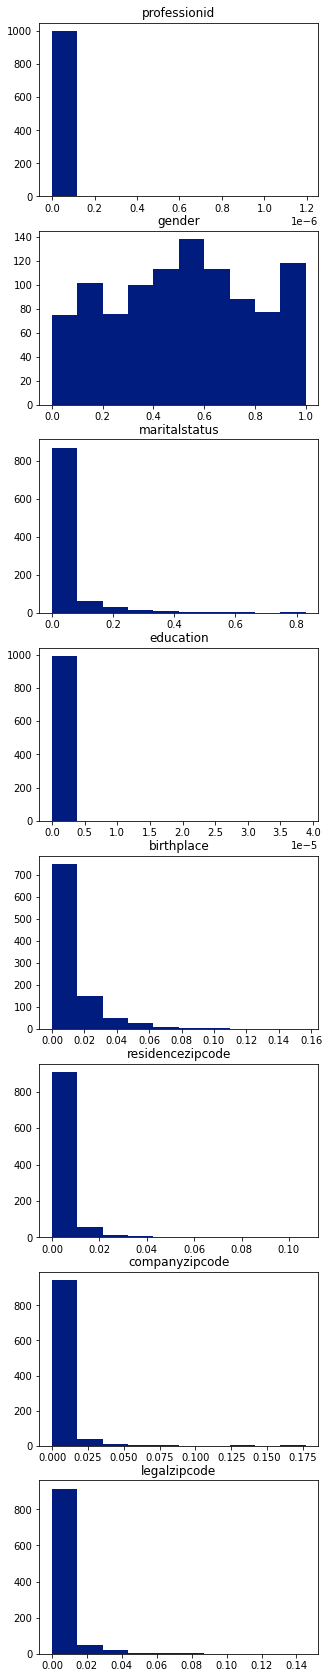

In [289]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(5, 30))
for i in range(len(cat)):
    plt.subplot(len(cat),1, i+1)
    plt.hist(pvalues[cat[i]])
    plt.title(cat[i])
plt.savefig("pvalue_" + cat[i] + ".png", bbox_inches="tight" )

jobtypeid not in my consideration because it is similar to professionid.

In [364]:
cat_final = ['professionid', 'birthplace', 'residencezipcode', 'companyzipcode', 'legalzipcode', 'education', 'maritalstatus']

Default rate in each profession?

In [293]:
profession_default = pd.crosstab(resample_df.professionid, resample_df.defaulted)
profession_default['rate'] = profession_default[True]/(profession_default[True]+profession_default[False])
profession_default.sort_values(by = 'rate')

defaulted,False,True,rate
professionid,,,
Government employees,2346,1269,0.351037
Professional,80,71,0.470199
Private Employees,8152,7352,0.474200
Army,39,42,0.518519
Entrepreneur,9383,11266,0.545595


Interestingly, government employees default the least, followed by professionals. Entrepreneur has higher rate to default, which makes sense as doing business involves more risk.

In [294]:
education_default = pd.crosstab(resample_df.education, resample_df.defaulted)
education_default['rate'] = education_default[True]/(education_default[True]+education_default[False])
education_default.sort_values(by = 'rate')

defaulted,False,True,rate
education,,,
MASTER_DEGREE,169,63,0.271552
BACHELOR_DEGREE,4166,2762,0.398672
DOCTOR_DEGREE,6,5,0.454545
TECHNICAL_COLLEGE,1496,1327,0.470067
SENIOR_HIGH_SCHOOL,11434,12185,0.515898
NOT_ATTENDING_SCHOOL,6,7,0.538462
ELEMENTARY_SCHOOL,952,1261,0.569815
JUNIOR_HIGH_SCHOOL,1771,2387,0.574074
OTHERS,0,3,1.000000


The higher the education degree, the lower the rate of default. Also makes sense.

In [366]:
mar_default = pd.crosstab(resample_df.maritalstatus, resample_df.defaulted)
mar_default['rate'] = mar_default[True]/(mar_default[True]+mar_default[False])
mar_default.sort_values(by = 'rate')

defaulted,False,True,rate
maritalstatus,,,
MARRIED,16828,16214,0.490709
SINGLE,2714,3088,0.532230
DIVORCE,323,479,0.597257
WIDOWED,135,217,0.616477


### Quantitative features

In [165]:
other = ['newapplicationdate', 'staysinceyear']

In [375]:
# feature engineering 
# previous: 1 means the person has record on loaning
resample_df['previous_converted']= resample_df.previous.apply(lambda x: 0 if pd.isnull(x) else 1)

In [376]:
quant = ['numofdependence', \
         'monthlyfixedincome', 'monthlyvariableincome', 'spouseincome', \
         'avg_income', 'std_income', 'avg_income_cnt', 'avg_income_nation', 'std_income_nation',
       'avg_income_nation_cnt', 'avg_income_area', 'std_icnome_area',
       'avg_income_area_cnt', 'avg_sale_house_price_5000',
       'std_sale_house_price_5000', 'sale_house_cnt_5000',
       'avg_sale_apartment_price_5000', 'std_sale_apartment_price_5000',
       'sale_apartment_cnt_5000', 'avg_rent_house_price_5000',
       'std_rent_house_price_5000', 'rent_house_cnt_5000',
       'avg_rent_apartment_price_5000', 'std_rent_apartment_price_5000',
       'rent_apartment_cnt_5000', 'avg_sale_house_price_10000',
       'std_sale_house_price_10000', 'sale_house_cnt_10000',
       'avg_sale_apartment_price_10000', 'std_sale_apartment_price_10000',
       'sale_apartment_cnt_10000', 'avg_rent_house_price_10000',
       'std_rent_house_price_10000', 'rent_house_cnt_10000',
       'avg_rent_apartment_price_10000', 'std_rent_apartment_price_10000',
       'rent_apartment_cnt_10000', 'previous_converted']

In [377]:
resample_df[quant].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numofdependence,40000.0,1.563250e+00,1.271629e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+01
monthlyfixedincome,40000.0,3.355249e+06,4.123721e+06,0.000000e+00,2.000000e+06,2.900000e+06,4.000000e+06,5.424148e+08
monthlyvariableincome,40000.0,1.700900e+05,1.014933e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+07
spouseincome,39997.0,3.590978e+04,5.162187e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.050000e+07
avg_income,39033.0,3.990832e+08,1.170629e+10,1.050000e+06,2.697935e+06,3.071558e+06,3.887109e+06,6.289339e+11
std_income,39033.0,2.273894e+10,6.281143e+11,0.000000e+00,1.366319e+06,1.899533e+06,3.334564e+06,2.507849e+13
avg_income_cnt,39033.0,3.385427e+03,4.819477e+03,1.000000e+00,4.820000e+02,1.666000e+03,4.003000e+03,3.036400e+04
avg_income_nation,39989.0,3.811316e+08,4.560916e+08,2.710989e+06,4.792272e+06,4.792272e+06,9.336151e+08,9.336151e+08
std_income_nation,39989.0,3.910413e+11,4.732870e+11,1.165207e+06,3.890322e+08,3.890322e+08,9.643547e+11,9.643547e+11
avg_income_nation_cnt,39989.0,1.172069e+06,3.664409e+05,6.400000e+01,1.075437e+06,1.418874e+06,1.418874e+06,1.418874e+06


In [378]:
# linear correlation
pcorr = dict()
for i in quant:
    pcorr[i] = scipy.stats.pearsonr(resample_df[i].fillna(resample_df[i].mean()), resample_df['MaxOverDueDays'])[0]
pcorr

{'numofdependence': -0.015197197976965279,
 'monthlyfixedincome': -0.050628610934531866,
 'monthlyvariableincome': 0.035173716323227855,
 'spouseincome': -0.010781338066413076,
 'avg_income': 0.0022668311907224114,
 'std_income': 0.002195994353719987,
 'avg_income_cnt': -0.066794381694159,
 'avg_income_nation': -0.07209105148258943,
 'std_income_nation': -0.07212681679772981,
 'avg_income_nation_cnt': 0.08451891030508607,
 'avg_income_area': 0.0044102411818818365,
 'std_icnome_area': 0.0048394689672424844,
 'avg_income_area_cnt': -0.08154051962885328,
 'avg_sale_house_price_5000': -0.019823535521733666,
 'std_sale_house_price_5000': -0.0021743990511476833,
 'sale_house_cnt_5000': -0.007109678091827824,
 'avg_sale_apartment_price_5000': -0.008596682051242026,
 'std_sale_apartment_price_5000': -0.03373139110109519,
 'sale_apartment_cnt_5000': 0.01682791707278333,
 'avg_rent_house_price_5000': 0.034227005965730466,
 'std_rent_house_price_5000': 0.04718933684242794,
 'rent_house_cnt_5000':

Other than "previous_converted" that demonstrates a strong negative linear correlation, linear correlation between the quantitative features and maxoverduedays seems trivial.

In [299]:
scipy.stats.pearsonr(resample_df.MaxOverDueDays, resample_df.defaulted)

(0.7263898026559368, 0.0)

72% large correlation for sure, because defaulted derives from MaxOverDueDays

# Feature Engineering

In [221]:
cat_final

['professionid',
 'residencezipcode',
 'companyzipcode',
 'legalzipcode',
 'education']

In [417]:
final_df = resample_df[cat_final]
final_df['index'] = resample_df.index

<ipython-input-417-e0a84d4cf259>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['index'] = resample_df.index


In [418]:
# label encoder on ordinal features
le = preprocessing.LabelEncoder()
final_df['professionid'] = le.fit_transform(resample_df.professionid)
final_df['education'] = le.fit_transform(resample_df.education)

<ipython-input-418-15bcae1d9645>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['professionid'] = le.fit_transform(resample_df.professionid)
<ipython-input-418-15bcae1d9645>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['education'] = le.fit_transform(resample_df.education)


In [383]:
non_ordinal = set(cat_final)^set(['professionid', 'education'])
list(non_ordinal)

['birthplace',
 'legalzipcode',
 'maritalstatus',
 'companyzipcode',
 'residencezipcode']

In [419]:
%%time
# Hashing Encoding for large scale categorical data
HE = ce.HashingEncoder(cols = non_ordinal, return_df=True, max_sample = 15000)
# encode the categorical variables
data = HE.fit_transform(final_df)

Wall time: 12.5 s


In [420]:
data.shape

(40000, 11)

In [451]:
#categorical features fillna with mode
data = data.apply(lambda x: x.fillna(x.mode()), axis=0)
#quantitative features fillna with mean
quant_data = resample_df[quant].apply(lambda x: x.fillna(x.mean()), axis=0)

In [638]:
X = quant_data.reset_index().merge(data, on = 'index').drop('index', axis = 1)
y = resample_df['defaulted']

In [639]:
X.shape, y.shape

((40000, 48), (40000,))

In [656]:
X

,numofdependence,monthlyfixedincome,monthlyvariableincome,spouseincome,avg_income,std_income,avg_income_cnt,avg_income_nation,std_income_nation,avg_income_nation_cnt,...,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,professionid,education
0,0,1760000.0,0.0,0.0,2.456146e+06,9.010644e+06,13082.0,9.336151e+08,9.643547e+11,1075437.0,...,1,1,0,0,3,0,0,0,3,0
1,1,3200000.0,0.0,0.0,3.197767e+06,1.643649e+06,1188.0,4.792272e+06,3.890322e+08,1418874.0,...,1,1,0,0,1,0,0,2,1,3
2,1,3500000.0,0.0,0.0,3.598656e+06,2.093555e+06,3000.0,4.792272e+06,3.890322e+08,1418874.0,...,3,0,0,1,1,0,0,0,1,7
3,3,0.0,950000.0,0.0,2.634084e+06,1.816447e+06,814.0,4.792272e+06,3.890322e+08,1418874.0,...,0,0,0,3,2,0,0,0,1,7
4,3,1200000.0,0.0,0.0,2.222745e+06,1.217200e+06,294.0,4.792272e+06,3.890322e+08,1418874.0,...,0,2,1,0,1,1,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1,1900000.0,0.0,0.0,2.494668e+06,8.730452e+05,343.0,3.039899e+06,3.545020e+07,18680.0,...,0,1,1,0,1,2,0,0,3,7
39996,1,3000000.0,3500000.0,0.0,3.752965e+06,1.940995e+06,55.0,3.595605e+06,2.733836e+06,25981.0,...,0,0,0,1,1,3,0,0,3,7
39997,1,5000000.0,0.0,0.0,8.114166e+07,2.487357e+09,1069.0,4.792272e+06,3.890322e+08,1418874.0,...,0,1,0,3,1,0,0,0,1,7
39998,3,2350574.0,0.0,0.0,3.169430e+06,1.942562e+06,1368.0,9.336151e+08,9.643547e+11,1075437.0,...,0,0,0,0,4,1,0,0,2,0


# Feature selection

In [575]:
# numerical feature selection using KBest
# chi because it's good for classification: Compute chi-squared stats between each non-negative feature and class.
X_quant = X[quant]
selector = SelectKBest(chi2, k=15)
selector.fit(X_quant, y)

SelectKBest(k=15, score_func=<function chi2 at 0x0000015762FAFE50>)

In [576]:
select_cols = selector.get_support(indices = True)
select_num_cols = X_quant.iloc[:,select_cols]
select_num_col_name = select_num_cols.columns
select_num_cols.head()

,avg_income,std_income,avg_income_nation,std_income_nation,avg_income_area,std_icnome_area,std_sale_apartment_price_5000,avg_rent_house_price_5000,std_rent_house_price_5000,std_rent_apartment_price_5000,avg_sale_house_price_10000,std_sale_apartment_price_10000,std_rent_house_price_10000,avg_rent_apartment_price_10000,std_rent_apartment_price_10000
0,2.456146e+06,9.010644e+06,9.336151e+08,9.643547e+11,2.727685e+06,6.765428e+06,1.349636e+08,3.670000e+07,3.936101e+07,6.716175e+06,1.099753e+09,4.209071e+09,3.936101e+07,8.668011e+06,1.180618e+07
1,3.197767e+06,1.643649e+06,4.792272e+06,3.890322e+08,3.044549e+06,1.569060e+06,2.568821e+08,5.565769e+07,4.625849e+07,7.643707e+07,5.212500e+08,1.940358e+08,4.625849e+07,5.366614e+06,2.020980e+07
2,3.598656e+06,2.093555e+06,4.792272e+06,3.890322e+08,3.407493e+06,1.970463e+06,8.390722e+07,3.550741e+07,2.221641e+07,1.034687e+07,7.866667e+08,2.242421e+08,2.777081e+07,3.978571e+06,4.601236e+06
3,2.634084e+06,1.816447e+06,4.792272e+06,3.890322e+08,2.741263e+06,1.595457e+06,5.076899e+07,4.255247e+07,2.247321e+07,2.247583e+07,6.479231e+08,1.427741e+08,8.359920e+07,4.000000e+06,4.134859e+06
4,2.222745e+06,1.217200e+06,4.792272e+06,3.890322e+08,2.242149e+06,1.184915e+06,3.616925e+09,5.285000e+07,3.765592e+07,5.164213e+08,2.481250e+08,3.616925e+09,2.428889e+07,3.881579e+06,3.984826e+06


In [484]:
# Select top 30 important numerical columns with RFE
# RFE: Recursive feature eliminaiton 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [577]:
selector = RFE(LogisticRegression(), n_features_to_select=15, step=1, verbose = 2)
selector = selector.fit(select_num_cols, y)
select_cols = selector.get_support(indices = True)
select_cols_df = select_num_cols.iloc[:,select_cols]

best_X_col_name = select_cols_df.columns
select_cols_df.head()

,avg_income,std_income,avg_income_nation,std_income_nation,avg_income_area,std_icnome_area,std_sale_apartment_price_5000,avg_rent_house_price_5000,std_rent_house_price_5000,std_rent_apartment_price_5000,avg_sale_house_price_10000,std_sale_apartment_price_10000,std_rent_house_price_10000,avg_rent_apartment_price_10000,std_rent_apartment_price_10000
0,2.456146e+06,9.010644e+06,9.336151e+08,9.643547e+11,2.727685e+06,6.765428e+06,1.349636e+08,3.670000e+07,3.936101e+07,6.716175e+06,1.099753e+09,4.209071e+09,3.936101e+07,8.668011e+06,1.180618e+07
1,3.197767e+06,1.643649e+06,4.792272e+06,3.890322e+08,3.044549e+06,1.569060e+06,2.568821e+08,5.565769e+07,4.625849e+07,7.643707e+07,5.212500e+08,1.940358e+08,4.625849e+07,5.366614e+06,2.020980e+07
2,3.598656e+06,2.093555e+06,4.792272e+06,3.890322e+08,3.407493e+06,1.970463e+06,8.390722e+07,3.550741e+07,2.221641e+07,1.034687e+07,7.866667e+08,2.242421e+08,2.777081e+07,3.978571e+06,4.601236e+06
3,2.634084e+06,1.816447e+06,4.792272e+06,3.890322e+08,2.741263e+06,1.595457e+06,5.076899e+07,4.255247e+07,2.247321e+07,2.247583e+07,6.479231e+08,1.427741e+08,8.359920e+07,4.000000e+06,4.134859e+06
4,2.222745e+06,1.217200e+06,4.792272e+06,3.890322e+08,2.242149e+06,1.184915e+06,3.616925e+09,5.285000e+07,3.765592e+07,5.164213e+08,2.481250e+08,3.616925e+09,2.428889e+07,3.881579e+06,3.984826e+06


In [578]:
set(select_cols_df.columns)^set(select_num_cols.columns)

set()

They returned the same columns of importance

# Model

## Model without filtering columns (without feature selection)

In [499]:
# Create training, testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Trying different models
- K-means Classifier
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost

In [670]:
def loan_model(model, X_train, X_test, y_train, y_test):
    output = {}
    clf = model
    clf.fit(X_train, y_train)
    output['clf_train_pred'] = sum(clf.predict(X_train) == y_train)/len(X_train)
    output['clf_test_pred'] = sum(clf.predict(X_test) == y_test)/len(X_test)

    output['mean_train_cvs'] =np.mean(cross_val_score(estimator = clf, y = y_train, X = X_train, cv=5, scoring='roc_auc'))
    output['mean_test_cvs'] =np.mean(cross_val_score(estimator = clf, y = y_test, \
                                                X = X_test, cv=5, scoring='roc_auc'))
    
    return output

In [671]:
%%time
sv = loan_model(svm.SVC(), X_train, X_test, y_train, y_test)
sv

Wall time: 10min 6s


{'clf_train_pred': 0.5004333333333333,
 'clf_test_pred': 0.4995,
 'mean_train_cvs': 0.5341736903567421,
 'mean_test_cvs': 0.5390419197362196}

In [672]:
%%time
decisiontree = loan_model(DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 2), X_train, X_test, y_train, y_test)
decisiontree

Wall time: 1.47 s


{'clf_train_pred': 0.5990333333333333,
 'clf_test_pred': 0.5845,
 'mean_train_cvs': 0.6103934716661548,
 'mean_test_cvs': 0.5870239392860392}

In [673]:
%%time
decisiontree2 = loan_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
decisiontree2

Wall time: 4.36 s


{'clf_train_pred': 0.9962333333333333,
 'clf_test_pred': 0.5463,
 'mean_train_cvs': 0.5471991910981088,
 'mean_test_cvs': 0.5334307144211146}

In [674]:
%%time
xgb = loan_model(XGBClassifier(gamma=0, learning_rate=0.1, max_depth=100, n_estimators=100), X_train, X_test, y_train, y_test)
xgb

[12:57:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use o

[12:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 20s


C:\Users\Yingyin\miniconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'clf_train_pred': 0.9960333333333333,
 'clf_test_pred': 0.5778,
 'mean_train_cvs': 0.6179536830810128,
 'mean_test_cvs': 0.602412247047147}

In [675]:
%%time
lr = loan_model(LogisticRegression(), X_train, X_test, y_train, y_test)
lr

C:\Users\Yingyin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Yingyin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

Wall time: 2.56 s


C:\Users\Yingyin\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'clf_train_pred': 0.5398,
 'clf_test_pred': 0.5449,
 'mean_train_cvs': 0.5450997687471052,
 'mean_test_cvs': 0.5554839208720208}

In [676]:
%%time
rfc = loan_model(RandomForestClassifier(max_depth = 5, min_samples_leaf = 2), X_train, X_test, y_train, y_test)
rfc

Wall time: 16.7 s


{'clf_train_pred': 0.6138666666666667,
 'clf_test_pred': 0.5938,
 'mean_train_cvs': 0.6438975619103131,
 'mean_test_cvs': 0.6349546579127578}

In [677]:
%%time
knn = loan_model(KNeighborsClassifier(), X_train, X_test, y_train, y_test)
knn

Wall time: 39 s


{'clf_train_pred': 0.7143333333333334,
 'clf_test_pred': 0.5581,
 'mean_train_cvs': 0.5897634372985708,
 'mean_test_cvs': 0.5670827298479298}

In [678]:
pd.DataFrame(data = [knn, lr, rfc, sv, decisiontree, xgb], index = ['knn', 'logistic', 'randomforest', \
                                                                    'supportvector', 'decisiontree', 'xgb'])

,clf_train_pred,clf_test_pred,mean_train_cvs,mean_test_cvs
knn,0.714333,0.5581,0.589763,0.567083
logistic,0.539800,0.5449,0.545100,0.555484
randomforest,0.613867,0.5938,0.643898,0.634955
supportvector,0.500433,0.4995,0.534174,0.539042
decisiontree,0.599033,0.5845,0.610393,0.587024
xgb,0.996033,0.5778,0.617954,0.602412


Timewise, SV takes around 10 minutes, XGBoost takes 1 min 11s, decision tree takes 1.37s, knn takes 42s, logistic regression takes 2.07s, and random forest takes 13.3s. XGBoost, KNN and SVM take large amount of time, so I decided to disregard them first. We have logistic regression, random forest, and decision tree left to be considered. 

<br> 

Among the three classifier, obviously, random forest classifier performs the best, as seen in its highest auc_roc score as well as the training and testing accuracy.

# Model improvement

## parameter tuning

We have decided to choose random forest classifier as our classifier. 

In [557]:
%%time
for depth in range(5,10):
    print(depth)
    rfc = loan_model(RandomForestClassifier(max_depth = depth, min_samples_leaf = 2))
    print(rfc)

5
{'clf_train_pred': 0.614, 'clf_test_pred': 0.5952, 'mean_cvs': 0.6429692952517958}
6
{'clf_train_pred': 0.6267, 'clf_test_pred': 0.6, 'mean_cvs': 0.6481618398971809}
7
{'clf_train_pred': 0.6403, 'clf_test_pred': 0.6022, 'mean_cvs': 0.6516104955429476}
8
{'clf_train_pred': 0.6573, 'clf_test_pred': 0.6028, 'mean_cvs': 0.6531257734365143}
9
{'clf_train_pred': 0.6770333333333334, 'clf_test_pred': 0.6072, 'mean_cvs': 0.6550271512128255}
Wall time: 1min 32s


As max_depth gets higher, training accuracy is higher, while testing accuracy stays relatively the same, which results in overfitting. 6 seems to be a good one. 

In [562]:
for leaf in range(1,5):
    print(leaf)
    rfc = loan_model(RandomForestClassifier(max_depth = 7, min_samples_leaf = leaf))
    print(rfc)

1
{'clf_train_pred': 0.6410666666666667, 'clf_test_pred': 0.6018, 'mean_cvs': 0.6507675288806439}
2
{'clf_train_pred': 0.6388, 'clf_test_pred': 0.602, 'mean_cvs': 0.6517753399991502}
3
{'clf_train_pred': 0.6386, 'clf_test_pred': 0.6024, 'mean_cvs': 0.6514532177811032}
4
{'clf_train_pred': 0.6392, 'clf_test_pred': 0.6016, 'mean_cvs': 0.6511671955512229}


In [681]:
loan_model(RandomForestClassifier(max_depth = 7, min_samples_leaf = 2), X_train, X_test, y_train, y_test)

{'clf_train_pred': 0.638,
 'clf_test_pred': 0.6011,
 'mean_train_cvs': 0.6516662400893847,
 'mean_test_cvs': 0.6394179594397593}

min_samples_leaf does not really change the performance much. Will take max_depth = 7 and min_samples_leaf = 2.

## using the filtered dataset

In [659]:
def loan_model(model, X_train, X_test, y_train, y_test):
    output = {}
    clf = model
    clf.fit(X_train, y_train)
    output['clf_train_pred'] = sum(clf.predict(X_train) == y_train)/len(X_train)
    output['clf_test_pred'] = sum(clf.predict(X_test) == y_test)/len(X_test)

    output['mean_train_cvs'] =np.mean(cross_val_score(estimator = clf, y = y_train, \
                                                X = X_train, cv=5, scoring='roc_auc'))
    output['mean_test_cvs'] =np.mean(cross_val_score(estimator = clf, y = y_test, \
                                                X = X_test, cv=5, scoring='roc_auc'))
    return output

In [625]:
# the filtered data is achieved by selecting 15 most important features determined by RFE/ SelectKBest
filtered_X = data.merge(select_cols_df, left_index = True, right_index = True)

In [682]:
# Create training, testing set
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(filtered_X, y, test_size=0.25, random_state=1)
filtered_rfc = loan_model(RandomForestClassifier(max_depth = 7, min_samples_leaf = 2), X_f_train, X_f_test, y_f_train, y_f_test)
filtered_rfc

{'clf_train_pred': 0.6227333333333334,
 'clf_test_pred': 0.5938,
 'mean_train_cvs': 0.6300731612770081,
 'mean_test_cvs': 0.6220846508193507}

Performance decreases a little.

## drop trivial features of Importance

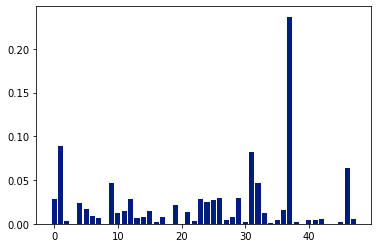

In [640]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
clf = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 2)
clf.fit(X_train, y_train)
importance = clf.feature_importances_
# summarize feature importance

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [642]:
sorted(dict_feature_importance.items(), key=lambda x: x[1], reverse=True)

[('previous_converted', 0.2367675302193217),
 ('monthlyfixedincome', 0.08922885896947111),
 ('avg_rent_house_price_10000', 0.0821719865048161),
 ('professionid', 0.06433166173362219),
 ('avg_income_nation_cnt', 0.047107230997770595),
 ('std_rent_house_price_10000', 0.04642413423904212),
 ('std_sale_house_price_10000', 0.029895615051910265),
 ('std_sale_apartment_price_10000', 0.029495263905653872),
 ('std_rent_apartment_price_5000', 0.02888082769943309),
 ('numofdependence', 0.02884944111748557),
 ('avg_income_area_cnt', 0.028727410001010183),
 ('avg_sale_house_price_10000', 0.02702623129570158),
 ('rent_apartment_cnt_5000', 0.02505832480601149),
 ('avg_income', 0.02427896929018938),
 ('avg_rent_house_price_5000', 0.020935365144900863),
 ('std_income', 0.01665667358340935),
 ('rent_apartment_cnt_10000', 0.016116058562271447),
 ('std_icnome_area', 0.014970137904392491),
 ('sale_house_cnt_5000', 0.01408608431170631),
 ('rent_house_cnt_5000', 0.013527144047142708),
 ('avg_income_area', 0.

In [648]:
dict_feature_importance = dict(zip(X_train.columns, importance))
trivial = []
for k,v in zip(X_train.columns, importance):
    if v == 0.0:
        trivial.append(k)

In [679]:
remaining_feat = set(X.columns)^set(trivial)
len(remaining_feat)

41

In [680]:
X_train, X_test, y_train, y_test = train_test_split(X[remaining_feat], y, test_size=0.25, random_state=1)
dropped_rfc = loan_model(RandomForestClassifier(max_depth = 7, min_samples_leaf = 2), X_train, X_test, y_train, y_test)
dropped_rfc

{'clf_train_pred': 0.6394,
 'clf_test_pred': 0.6041,
 'mean_train_cvs': 0.6510398511482736,
 'mean_test_cvs': 0.6409332598700599}

Improved slightly.

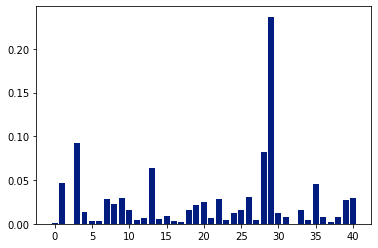

In [654]:
clf = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 2)
clf.fit(X_train, y_train)
importance = clf.feature_importances_
# summarize feature importance

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [655]:
dic = (dict(zip(X_train.columns, importance)))
sorted(dic.items(), key=lambda x: x[1], reverse=True)

[('previous_converted', 0.2367675302193217),
 ('monthlyfixedincome', 0.09217344638561248),
 ('avg_rent_house_price_10000', 0.0821719865048161),
 ('professionid', 0.06433166173362219),
 ('avg_income_nation_cnt', 0.047107230997770595),
 ('std_rent_house_price_10000', 0.04596486050610582),
 ('avg_income_area_cnt', 0.030088221061562177),
 ('std_sale_apartment_price_10000', 0.029495263905653872),
 ('std_sale_house_price_10000', 0.029385310904203262),
 ('std_rent_apartment_price_5000', 0.02888082769943309),
 ('numofdependence', 0.028785653099022195),
 ('avg_sale_house_price_10000', 0.027613302936933197),
 ('rent_apartment_cnt_5000', 0.02505832480601149),
 ('avg_income', 0.02286761381881688),
 ('avg_rent_house_price_5000', 0.020935365144900863),
 ('sale_house_cnt_5000', 0.0162633820085895),
 ('rent_apartment_cnt_10000', 0.016116058562271447),
 ('std_income', 0.01586995468902773),
 ('std_icnome_area', 0.015578699372465431),
 ('rent_house_cnt_5000', 0.013527144047142708),
 ('rent_house_cnt_1000